# Credit Card Default
August 15, 2019<br>Ngoc, Modeling Transformed Data

-----------------------------------------------------------------

In this notebook, we will perform modeling for transformed data.

----------------------------------------------

# Import

In [1]:
%matplotlib inline

import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.svm import SVC
from datetime import datetime
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_curve, roc_auc_score

sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

Change directory to get data source code:

In [2]:
main_path = os.getcwd()
parent_path = Path(os.getcwd()).parent
src_path = str(parent_path) + "/src/directories"
os.chdir(src_path)

More import:

In [3]:
import change_directory

Change back to notebook directory:

In [4]:
os.chdir(main_path)

Change directory to get helper functions:

In [5]:
cd = change_directory.ChangeDirectory()

In [6]:
cd.change_to_src_models_dir()

More import:

In [7]:
import evaluation_functions
all_scores = evaluation_functions.all_scores
scores_confusion_matrix = evaluation_functions.scores_confusion_matrix

Change back to notebook directory:

In [8]:
cd.change_to_notebook_dir()

# ETL

## Load data

Change directory to get data:

In [9]:
cd.change_to_data_dir()

Load data:

In [10]:
ccd_df = pd.read_csv("processed/transformed_credit_card_default.csv")

Change back to notebook directory:

In [11]:
cd.change_to_notebook_dir()

## Sample data
Methods to tackle imbalance: over-sampling, under-sampling, and SMOTE.

In [12]:
ccd_df.drop("Unnamed: 0", axis=1, inplace=True)

In [13]:
ccd_ns = ccd_df.copy()
ccd_ou = ccd_df.copy()
ccd_smote = ccd_df.copy()

### Over-sampling

In [14]:
default_samples = ccd_ou[ccd_ou.DEFAULT == 1]
non_default_samples = ccd_ou[ccd_ou.DEFAULT == 0]

In [15]:
default_samples_train, default_samples_test = train_test_split(default_samples,
                                                               test_size=0.2,
                                                               random_state=111)
non_default_samples_train, non_default_samples_test = train_test_split(non_default_samples,
                                                                       test_size=0.2,
                                                                       random_state=111)

In [16]:
np.random.seed(42)
os_default_idx = np.random.choice(default_samples_train.index,
                                  size=non_default_samples_train.shape[0], replace=True)
os_default = default_samples_train.loc[os_default_idx, :]

In [17]:
ccd_over_sampled_train = pd.concat([os_default, non_default_samples_train], axis=0)
X_over_sampled_train = ccd_over_sampled_train.drop("DEFAULT", axis=1)
y_over_sampled_train = ccd_over_sampled_train.DEFAULT

ccd_over_sampled_test = pd.concat([default_samples_test, non_default_samples_test], axis=0)
X_over_sampled_test = ccd_over_sampled_test.drop("DEFAULT", axis=1)
y_over_sampled_test = ccd_over_sampled_test.DEFAULT

### Under-sampling

In [18]:
np.random.seed(42)
us_non_default_idx = np.random.choice(non_default_samples.index, size=default_samples.shape[0], replace=False)
us_non_default = non_default_samples.loc[us_non_default_idx, :]

In [19]:
ccd_under_sampled = pd.concat([us_non_default, default_samples], axis=0)
X_under_sampled = ccd_under_sampled.drop("DEFAULT", axis=1)
y_under_sampled = ccd_under_sampled.DEFAULT
X_under_sampled_train, X_under_sampled_test, y_under_sampled_train, y_under_sampled_test = train_test_split(X_under_sampled, y_under_sampled, test_size=0.2, random_state=111)

### SMOTE

In [20]:
X_smote = ccd_smote.drop("DEFAULT", axis=1)
y_smote = ccd_smote.DEFAULT
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote,
                                                                            test_size=0.2, random_state=111)
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_smote_train, y_smote_train)

## Data for modeling

In [21]:
# non-sampled
X_non_sampled = ccd_ns.drop("DEFAULT", axis=1)
y_non_sampled = ccd_ns.DEFAULT
non_sampled_X_train, non_sampled_X_test, non_sampled_y_train, non_sampled_y_test = train_test_split(X_non_sampled,
                                                                                                    y_non_sampled,
                                                                                                    test_size=0.2,
                                                                                                    random_state=111)

In [22]:
# over-sampled
over_sampled_X_train = X_over_sampled_train
over_sampled_y_train = y_over_sampled_train
over_sampled_X_test = X_over_sampled_test
over_sampled_y_test = y_over_sampled_test

In [23]:
# under-sampled
under_sampled_X_train = X_under_sampled_train
under_sampled_y_train = y_under_sampled_train
under_sampled_X_test = X_under_sampled_test
under_sampled_y_test = y_under_sampled_test

In [24]:
# SMOTE
smote_sampled_X_train = X_sm
smote_sampled_y_train = y_sm
smote_sampled_X_test = X_smote_test
smote_sampled_y_test = y_smote_test

# Model

## Non-sampled

### Logistic Regression

In [25]:
ns_lr = LogisticRegression()
param_grid = {"penalty": ["l1", "l2"],
              "C": [0.01, 0.1, 1, 10],
              "class_weight": ["balanced", None],
              "random_state": [42],
              "solver": ["liblinear"], 
              "n_jobs": [-1]}
ns_lr_gs = GridSearchCV(ns_lr, param_grid, cv=3, scoring="recall", n_jobs=-1)
ns_lr_gs.fit(non_sampled_X_train, non_sampled_y_train);
ns_lr_gs.best_params_

{'C': 10,
 'class_weight': 'balanced',
 'n_jobs': -1,
 'penalty': 'l1',
 'random_state': 42,
 'solver': 'liblinear'}

Evaluate the best logistic model:

Training Scores:
f-1 score: 0.5430930810550789
recall: 0.6342696629213483
precision:0.4748352726762933
Test Scores:
f-1 score: 0.5164319248826291
recall: 0.5941358024691358
precision:0.45670225385527874


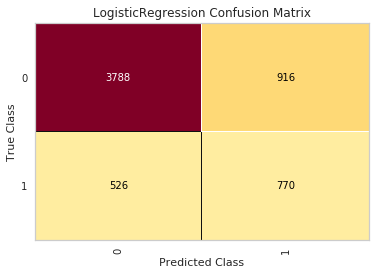

In [26]:
scores_confusion_matrix(ns_lr_gs, non_sampled_X_train, non_sampled_X_test,
                        non_sampled_y_train, non_sampled_y_test)

### Decision Tree

In [27]:
ns_dt = DecisionTreeClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [None, 8, 10],
              "min_samples_split": [10, 25],
              "min_samples_leaf": [1, 5],
              "max_features": [None, "sqrt"],
              "class_weight": ["balanced", None],
              "random_state": [42]}
ns_dt_gs = GridSearchCV(ns_dt, param_grid, cv=3, scoring="recall", n_jobs=-1)
ns_dt_gs.fit(non_sampled_X_train, non_sampled_y_train);
ns_dt_gs.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 25,
 'random_state': 42}

Evaluate the best decision tree model:

Training Scores:
f-1 score: 0.5354296478771193
recall: 0.6919475655430711
precision:0.4366580004727015
Test Scores:
f-1 score: 0.48752969121140144
recall: 0.6334876543209876
precision:0.39623552123552125


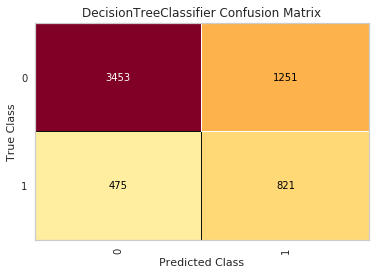

In [28]:
scores_confusion_matrix(ns_dt_gs, non_sampled_X_train, non_sampled_X_test,
                        non_sampled_y_train, non_sampled_y_test)

### Random Forest

In [29]:
ns_rf = RandomForestClassifier()
param_grid = {"n_estimators": [50, 100, 200],
              "criterion": ["gini", "entropy"],
              "max_depth": [None, 8, 10],
              "min_samples_split": [10, 25],
              "min_samples_leaf": [1, 5],
              "max_features": [None, "sqrt"],
              "class_weight": ["balanced", None],
              "random_state": [42],
              "n_jobs": [-1]}
ns_rf_gs = GridSearchCV(ns_rf, param_grid, cv=3, scoring="recall", n_jobs=-1)
ns_rf_gs.fit(non_sampled_X_train, non_sampled_y_train);
ns_rf_gs.best_params_

KeyboardInterrupt: 

Evaluate the best random forest model:

In [ ]:
scores_confusion_matrix(ns_rf_gs, non_sampled_X_train, non_sampled_X_test,
                        non_sampled_y_train, non_sampled_y_test)

### XGBoost

In [ ]:
ns_xgb = xgb.XGBRegressor()
param_grid = {"max_depth": [5, 8, 10],
              "learning_rate": [0.01, 0.1, 1, 10, 100],
              "objective": ["binary:hinge"],
              "n_estimators": [10, 50, 100, 150],
              "n_jobs": [-1],
              "random_state": [42]}
ns_xgb_gs = GridSearchCV(ns_xgb, param_grid, cv=3, scoring="recall", n_jobs=-1)
ns_xgb_gs.fit(non_sampled_X_train, non_sampled_y_train);
ns_xgb_gs.best_params_

Evaluate the best XGBoost model:

In [ ]:
best_ns_xgb = xgb.XGBRegressor(**ns_xgb_gs.best_params_)
best_ns_xgb.fit(non_sampled_X_train, non_sampled_y_train)
y_preds_best_ns_xgb = best_ns_xgb.predict(non_sampled_X_test)
evaluation_functions.all_scores(non_sampled_y_test, y_preds_best_ns_xgb)

### SVM

In [ ]:
# ns_svm = SVC()
# param_grid = {"C": [0.1, 1, 10],
#               "kernel": ["linear", "rbf"],
#               "class_weight": ["balanced", None],
#               "random_state": [42]}
# ns_svm_gs = GridSearchCV(ns_svm, param_grid, cv=3, scoring="recall", n_jobs=-1)
# ns_svm_gs.fit(non_sampled_X_train, non_sampled_y_train);
# ns_svm_gs.best_params_

Evaluate the best SVM model:

In [ ]:
# best_ns_svm = SVC(**ns_svm_gs.best_params_)
# best_ns_svm.fit(non_sampled_X_train, non_sampled_y_train)
# y_preds_best_ns_svm = best_ns_svm.predict(non_sampled_X_test)
# all_scores(non_sampled_y_test, y_preds_best_ns_svm)

## Over-sampled

### Logistic Regression

In [ ]:
os_lr = LogisticRegression()
param_grid = {"penalty": ["l1", "l2"],
              "C": [0.01, 0.1, 1, 10],
              "class_weight": ["balanced", None],
              "random_state": [42],
              "solver": ["liblinear"], 
              "n_jobs": [-1]}
os_lr_gs = GridSearchCV(os_lr, param_grid, cv=3, scoring="recall", n_jobs=-1)
os_lr_gs.fit(over_sampled_X_train, over_sampled_y_train);
os_lr_gs.best_params_

Evaluate the best logistic model:

In [ ]:
scores_confusion_matrix(os_lr_gs, over_sampled_X_train, over_sampled_X_test,
                        over_sampled_y_train, over_sampled_y_test)

### Decision Tree

In [ ]:
os_dt = DecisionTreeClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [None, 8, 10],
              "min_samples_split": [10, 25],
              "min_samples_leaf": [1, 5],
              "max_features": [None, "sqrt"],
              "class_weight": ["balanced", None],
              "random_state": [42]}
os_dt_gs = GridSearchCV(os_dt, param_grid, cv=3, scoring="recall", n_jobs=-1)
os_dt_gs.fit(over_sampled_X_train, over_sampled_y_train);
os_dt_gs.best_params_

Evaluate the best decision tree model:

In [ ]:
scores_confusion_matrix(os_dt_gs, over_sampled_X_train, over_sampled_X_test,
                        over_sampled_y_train, over_sampled_y_test)

### Random Forest

In [ ]:
os_rf = RandomForestClassifier()
param_grid = {"n_estimators": [50, 100, 200],
              "criterion": ["gini", "entropy"],
              "max_depth": [None, 8, 10],
              "min_samples_split": [10, 25],
              "min_samples_leaf": [1, 5],
              "max_features": [None, "sqrt"],
              "class_weight": ["balanced", None],
              "random_state": [42],
              "n_jobs": [-1]}
os_rf_gs = GridSearchCV(os_rf, param_grid, cv=3, scoring="recall", n_jobs=-1)
os_rf_gs.fit(over_sampled_X_train, over_sampled_y_train);
os_rf_gs.best_params_

Evaluate the best random forest model:

In [ ]:
scores_confusion_matrix(os_rf_gs, over_sampled_X_train, over_sampled_X_test,
                        over_sampled_y_train, over_sampled_y_test)

### XGBoost

In [ ]:
os_xgb = xgb.XGBRegressor()
param_grid = {"max_depth": [5, 8, 10],
              "learning_rate": [0.01, 0.1, 1, 10, 100],
              "objective": ["binary:hinge"],
              "n_estimators": [10, 50, 100, 150],
              "n_jobs": [-1],
              "random_state": [42]}
os_xgb_gs = GridSearchCV(os_xgb, param_grid, cv=3, scoring="recall", n_jobs=-1)
os_xgb_gs.fit(over_sampled_X_train, over_sampled_y_train);
os_xgb_gs.best_params_

Evaluate the best XGBoost model:

In [ ]:
best_os_xgb = xgb.XGBRegressor(**os_xgb_gs.best_params_)
best_os_xgb.fit(over_sampled_X_train, over_sampled_y_train)
y_preds_best_os_xgb = best_os_xgb.predict(over_sampled_X_test)
all_scores(over_sampled_y_test, y_preds_best_os_xgb)

### SVM

In [ ]:
# os_svm = SVC()
# param_grid = {"C": [0.1, 1, 10],
#               "kernel": ["linear", "rbf"],
#               "class_weight": ["balanced", None],
#               "random_state": [42]}
# os_svm_gs = GridSearchCV(os_svm, param_grid, cv=3, scoring="recall", n_jobs=-1)
# os_svm_gs.fit(over_sampled_X_train, over_sampled_y_train);
# os_svm_gs.best_params_

Evaluate the best SVM model:

In [ ]:
# best_os_svm = SVC(**os_svm_gs.best_params_)
# best_os_svm.fit(over_sampled_X_train, over_sampled_y_train)
# y_preds_best_os_svm = best_os_svm.predict(over_sampled_X_test)
# all_scores(over_sampled_y_test, y_preds_best_os_svm)

## Under-sampled

### Logistic Regression

In [ ]:
us_lr = LogisticRegression()
param_grid = {"penalty": ["l1", "l2"],
              "C": [0.01, 0.1, 1, 10],
              "class_weight": ["balanced", None],
              "random_state": [42],
              "solver": ["liblinear"], 
              "n_jobs": [-1]}
us_lr_gs = GridSearchCV(us_lr, param_grid, cv=3, scoring="recall", n_jobs=-1)
us_lr_gs.fit(under_sampled_X_train, under_sampled_y_train);
us_lr_gs.best_params_

Evaluate the best logistic model:

In [ ]:
scores_confusion_matrix(us_lr_gs, under_sampled_X_train, under_sampled_X_test,
                        under_sampled_y_train, under_sampled_y_test)

### Decision Tree

In [ ]:
us_dt = DecisionTreeClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [None, 8, 10],
              "min_samples_split": [10, 25],
              "min_samples_leaf": [1, 5],
              "max_features": [None, "sqrt"],
              "class_weight": ["balanced", None],
              "random_state": [42]}
us_dt_gs = GridSearchCV(us_dt, param_grid, cv=3, scoring="recall", n_jobs=-1)
us_dt_gs.fit(under_sampled_X_train, under_sampled_y_train);
us_dt_gs.best_params_

Evaluate the best decision tree model:

In [ ]:
scores_confusion_matrix(us_dt_gs, under_sampled_X_train, under_sampled_X_test,
                        under_sampled_y_train, under_sampled_y_test)

### Random Forest

In [ ]:
us_rf = RandomForestClassifier()
param_grid = {"n_estimators": [50, 100, 200],
              "criterion": ["gini", "entropy"],
              "max_depth": [None, 8, 10],
              "min_samples_split": [10, 25],
              "min_samples_leaf": [1, 5],
              "max_features": [None, "sqrt"],
              "class_weight": ["balanced", None],
              "random_state": [42],
              "n_jobs": [-1]}
us_rf_gs = GridSearchCV(us_rf, param_grid, cv=3, scoring="recall", n_jobs=-1)
us_rf_gs.fit(under_sampled_X_train, under_sampled_y_train);
us_rf_gs.best_params_

Evaluate the best random forest model:

In [ ]:
scores_confusion_matrix(us_rf_gs, under_sampled_X_train, under_sampled_X_test,
                        under_sampled_y_train, under_sampled_y_test)

### XGBoost

In [ ]:
us_xgb = xgb.XGBRegressor()
param_grid = {"max_depth": [5, 8, 10],
              "learning_rate": [0.01, 0.1, 1, 10, 100],
              "objective": ["binary:hinge"],
              "n_estimators": [10, 50, 100, 150],
              "n_jobs": [-1],
              "random_state": [42]}
us_xgb_gs = GridSearchCV(us_xgb, param_grid, cv=3, scoring="recall", n_jobs=-1)
us_xgb_gs.fit(under_sampled_X_train, under_sampled_y_train);
us_xgb_gs.best_params_

Evaluate the best XGBoost model:

In [ ]:
best_us_xgb = xgb.XGBRegressor(**us_xgb_gs.best_params_)
best_us_xgb.fit(under_sampled_X_train, under_sampled_y_train)
y_preds_best_us_xgb = best_us_xgb.predict(under_sampled_X_test)
all_scores(under_sampled_y_test, y_preds_best_us_xgb)

### SVM

In [ ]:
# us_svm = SVC()
# param_grid = {"C": [0.1, 1, 10],
#               "kernel": ["linear", "rbf"],
#               "class_weight": ["balanced", None],
#               "random_state": [42]}
# us_svm_gs = GridSearchCV(us_svm, param_grid, cv=3, scoring="recall", n_jobs=-1)
# us_svm_gs.fit(under_sampled_X_train, under_sampled_y_train);
# us_svm_gs.best_params_

Evaluate the best SVM model:

In [ ]:
# best_us_svm = SVC(**us_svm_gs.best_params_)
# best_us_svm.fit(under_sampled_X_train, under_sampled_y_train)
# y_preds_best_us_svm = best_us_svm.predict(under_sampled_X_test)
# all_scores(under_sampled_y_test, y_preds_best_us_svm)

## SMOTE-sampled

### Logistic Regression

In [ ]:
sm_lr = LogisticRegression()
param_grid = {"penalty": ["l1", "l2"],
              "C": [0.01, 0.1, 1, 10],
              "class_weight": ["balanced", None],
              "random_state": [42],
              "solver": ["liblinear"], 
              "n_jobs": [-1]}
sm_lr_gs = GridSearchCV(sm_lr, param_grid, cv=3, scoring="recall", n_jobs=-1)
sm_lr_gs.fit(smote_sampled_X_train, smote_sampled_y_train);
sm_lr_gs.best_params_

Evaluate the best logistic model:

In [ ]:
scores_confusion_matrix(sm_lr_gs, smote_sampled_X_train, smote_sampled_X_test,
                        smote_sampled_y_train, smote_sampled_y_test)

### Decision Tree

In [ ]:
sm_dt = DecisionTreeClassifier()
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth": [None, 8, 10],
              "min_samples_split": [10, 25],
              "min_samples_leaf": [1, 5],
              "max_features": [None, "sqrt"],
              "class_weight": ["balanced", None],
              "random_state": [42]}
sm_dt_gs = GridSearchCV(sm_dt, param_grid, cv=3, scoring="recall", n_jobs=-1)
sm_dt_gs.fit(smote_sampled_X_train, smote_sampled_y_train);
sm_dt_gs.best_params_

Evaluate the best decision tree model:

In [ ]:
scores_confusion_matrix(sm_dt_gs, smote_sampled_X_train, smote_sampled_X_test,
                        smote_sampled_y_train, smote_sampled_y_test)

### Random Forest

In [ ]:
sm_rf = RandomForestClassifier()
param_grid = {"n_estimators": [50, 100, 200],
              "criterion": ["gini", "entropy"],
              "max_depth": [None, 8, 10],
              "min_samples_split": [10, 25],
              "min_samples_leaf": [1, 5],
              "max_features": [None, "sqrt"],
              "class_weight": ["balanced", None],
              "random_state": [42],
              "n_jobs": [-1]}
sm_rf_gs = GridSearchCV(sm_rf, param_grid, cv=3, scoring="recall", n_jobs=-1)
sm_rf_gs.fit(smote_sampled_X_train, smote_sampled_y_train);
sm_rf_gs.best_params_

Evaluate the best random forest model:

In [ ]:
scores_confusion_matrix(sm_rf_gs, smote_sampled_X_train, smote_sampled_X_test,
                        smote_sampled_y_train, smote_sampled_y_test)

### XGBoost

In [ ]:
sm_xgb = xgb.XGBRegressor()
param_grid = {"max_depth": [5, 8, 10],
              "learning_rate": [0.01, 0.1, 1, 10, 100],
              "objective": ["binary:hinge"],
              "n_estimators": [10, 50, 100, 150],
              "n_jobs": [-1],
              "random_state": [42]}
sm_xgb_gs = GridSearchCV(sm_xgb, param_grid, cv=3, scoring="recall", n_jobs=-1)
sm_xgb_gs.fit(smote_sampled_X_train, smote_sampled_y_train);
sm_xgb_gs.best_params_

Evaluate the best XGBoost model:

In [ ]:
best_sm_xgb = xgb.XGBRegressor(**sm_xgb_gs.best_params_)
best_sm_xgb.fit(smote_sampled_X_train, smote_sampled_y_train)
y_preds_best_sm_xgb = best_sm_xgb.predict(smote_sampled_X_test)
all_scores(smote_sampled_y_test, y_preds_best_sm_xgb)

### SVM

In [ ]:
# sm_svm = SVC()
# param_grid = {"C": [0.1, 1, 10],
#               "kernel": ["linear", "rbf"],
#               "class_weight": ["balanced", None],
#               "random_state": [42]}
# sm_svm_gs = GridSearchCV(sm_svm, param_grid, cv=3, scoring="recall", n_jobs=-1)
# sm_svm_gs.fit(smote_sampled_X_train, smote_sampled_y_train);
# sm_svm_gs.best_params_

Evaluate the best SVM model:

In [ ]:
# best_sm_svm = SVC(**sm_svm_gs.best_params_)
# best_sm_svm.fit(smote_sampled_X_train, smote_sampled_y_train)
# y_preds_best_sm_svm = best_sm_svm.predict(smote_sampled_X_test)
# all_scores(smote_sampled_y_test, y_preds_best_sm_svm)